## Multiclass Emoji Classifier using BERT 

### Author: Han Yu 
#### Last Update Date: Oct 08, 2020

### Install Library

In [1]:
# Watermark: IPython magic extension for printing date and time stamps, version numbers, and hardware information
!pip install -q -U watermark

In [2]:
# Transformer: State-of-the-art Natural Language Processing for PyTorch and TensorFlow 2.0
!pip install transformers==2.11.0

In [3]:
# columnize: Format a simple (i.e., not nested) list into aligned columns
!pip install columnize

In [4]:
# Print out key libraries' versions 
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.7.7
IPython 7.16.1

numpy 1.19.1
pandas 1.0.5
torch 1.6.0
transformers 2.11.0


### Import Library

In [5]:
# util library
import ast
import columnize
from collections import defaultdict
import emoji 
from textwrap import wrap

# ML/NLP/NLU library
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Data Analytics/Visualization library
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

### Common Configuration Setup

In [6]:
# Visualization Config 
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 10

# PyTorch Config 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Pandas Config
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Exploratory Data Analysis

In [7]:
df = pd.read_csv("data/tweet_emoji_train_200000.csv")
# df = df.head(5000)
df.head()

,id,tweet,emoji
0,0,CeeC is going to be another Tboss What is 45 million Naira,['face_with_tears_of_joy']
1,1,This gif kills me Death is literally gushing towards you and you really gon do a whole 3point turn,['weary_face']
2,2,LOVE TEST Raw Real JaDine,['purple_heart']
3,3,i swear we dont gotta look it finds us,['face_with_tears_of_joy']
4,4,We would like to wish everyone a very Happy New Year and all the best in 2018,['party_popper']


In [8]:
df = df.drop('id', 1) # drop id column
df = df.drop_duplicates(subset=['tweet'], keep=False) # drop duplicated tweet
df = df.dropna(how='any',axis=0)  # drop any sample with null attribute

In [9]:
# check if dataset only contains unique tweet
print('Contains only unique tweets: ', df.tweet.nunique() == df.shape[0]) 
# check if dataset contains any sample with null attribute 
print('Contains Null values: ', df.isnull().values.any())

Contains only unique tweets:  True
Contains Null values:  False


In [10]:
# convert column "emoji" to "set", so duplicated emoji will be removed 
df['emoji'] = df['emoji'].apply(lambda x: set(ast.literal_eval(x))) 
# then convert column "emoji" to "list", so it is hashable 
df.emoji= df.emoji.apply(list)
# peek the head and see if dataframe transformation is working as expected 
df.head()

,tweet,emoji
0,CeeC is going to be another Tboss What is 45 million Naira,[face_with_tears_of_joy]
2,LOVE TEST Raw Real JaDine,[purple_heart]
4,We would like to wish everyone a very Happy New Year and all the best in 2018,[party_popper]
6,just know ilysm k bye friend,[purple_heart]
7,Too glam to give a damn,[sparkles]


In [11]:
# check the summary info of dataframe 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153788 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweet   153788 non-null  object
 1   emoji   153788 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [21]:
# helper functions to get the distinct emoji in the dataset
def get_distinct_emoji(emoji_column:pd.core.series.Series)->set:
    emoji_set = set()
    for emojis in emoji_column:
        for x in emojis: 
            emoji_set.add(x)
    return emoji_set

def format_emoji(e):
    return emoji.emojize(':'+ e +':')

def print_distinct_emoji_in_dataset(emoji_set:set):
    print('Total distinct count of Emojis in dataset is : {}'.format(len(emoji_set)))
    emoji_set_formatted = [format_emoji(e) for e in emoji_set]
    print(columnize.columnize(emoji_set_formatted, displaywidth=20))

# get the distinct emoji from dataset to be used for building the emoji multiclass classifier 
emoji_class = get_distinct_emoji(df.emoji)
print_distinct_emoji_in_dataset(sorted(list(emoji_class)))

Total distinct count of Emojis in dataset is : 49
👌  😢  🔥  💯  💜  😍  👍
👇  ‼  💪  😭  🙌  😊  🏆
👉  👀  😳  ♂  ❤  😎  💕
😁  😘  🙏  🎉  ➡  ✨  😩
💙  🙄  🌟  🤦  🤣  💖  ✅
👏  😂  ♥  🤷  💀  🗣  😉
💥  ♀  ✔  🚨  ☺  🤔  💛



In [13]:
# Since most of the tweets in the dataset only contain one emoji, we will build a multiclass classifier
# instead of building a multilable classifier 

# So, we will build a multiclass dataset with tweets which only contain one emoji 
df_multiclass_dataset = df[df['emoji'].apply(lambda x: len(x)==1)].copy()
# Create a column "label", to save the emoji info for each tweet in the dataset
df_multiclass_dataset['label'] = df_multiclass_dataset['emoji'].apply(lambda x: x[0])

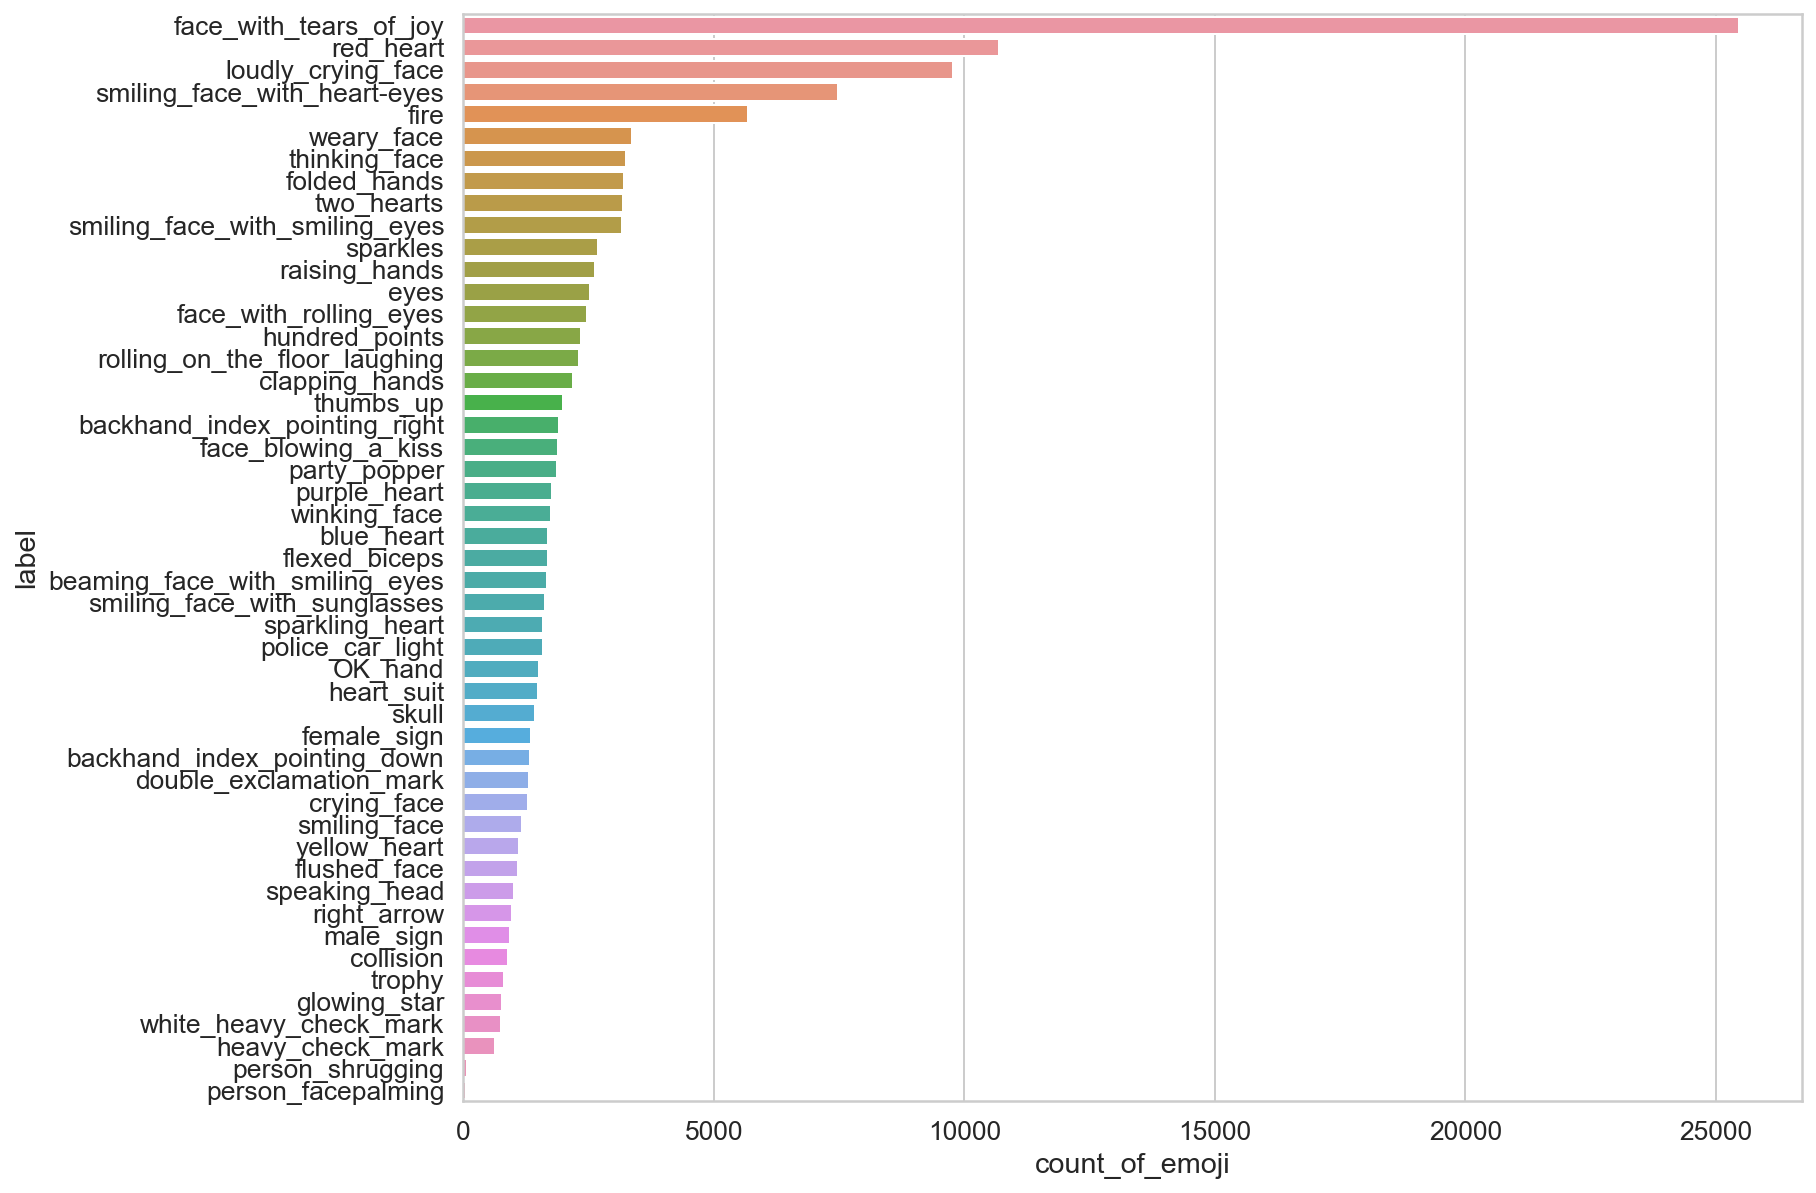

In [14]:
# Print out the count of each class (e.g., each emoji) in the dataset
order = df_multiclass_dataset['label'].value_counts(ascending=False).index
sns.countplot(y="label", data=df_multiclass_dataset, order=order)
plt.xlabel('count_of_emoji');

In [15]:
df_multiclass_dataset['label'].unique()

array(['face_with_tears_of_joy', 'purple_heart', 'party_popper',
       'sparkles', 'clapping_hands', 'loudly_crying_face', 'fire',
       'hundred_points', 'red_heart', 'raising_hands',
       'smiling_face_with_heart-eyes', 'trophy', 'speaking_head',
       'weary_face', 'beaming_face_with_smiling_eyes',
       'backhand_index_pointing_down', 'two_hearts', 'heart_suit',
       'male_sign', 'thumbs_up', 'folded_hands', 'flexed_biceps',
       'face_blowing_a_kiss', 'smiling_face', 'face_with_rolling_eyes',
       'crying_face', 'police_car_light', 'OK_hand', 'blue_heart',
       'winking_face', 'flushed_face', 'white_heavy_check_mark',
       'female_sign', 'smiling_face_with_sunglasses',
       'double_exclamation_mark', 'smiling_face_with_smiling_eyes',
       'thinking_face', 'backhand_index_pointing_right', 'collision',
       'rolling_on_the_floor_laughing', 'yellow_heart', 'eyes',
       'sparkling_heart', 'skull', 'glowing_star', 'heavy_check_mark',
       'right_arrow', 'perso

##### Note: From the countplot above, we can see that the emoji labels are not balanced among sample data; for example, "face_with_tears_of_joy" is the most used emoji in the dataset.

In [16]:
emoji_class = ['face_with_tears_of_joy','red_heart',
               'loudly_crying_face','smiling_face_with_heart-eyes', 
               'fire', 'weary_face', 
               'thinking_face', 'folded_hands', 
               'two_hearts', 'smiling_face_with_smiling_eyes',
               'sparkles', 'raising_hands', 
               'eyes', 'face_with_rolling_eyes',
               'hundred_points', 'rolling_on_the_floor_laughing',
               'clapping_hands', 'thumbs_up', 
               'face_blowing_a_kiss', 'party_popper']
print_distinct_emoji_in_dataset(emoji_class)
df_multiclass_dataset = df_multiclass_dataset[df_multiclass_dataset['label'].isin(emoji_class)]
# df_multiclass_dataset_balanced=df_multiclass_dataset.groupby('label',as_index = False,group_keys=False)\
# .apply(lambda s: s.sample(200,replace=True))

# Samples equal size of each class with sample size as the size of the class with minimum number of data.
g = df_multiclass_dataset.groupby('label', as_index = False, group_keys=False)
df_multiclass_dataset_balanced = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
print(df_multiclass_dataset_balanced['label'].value_counts())

Total distinct count of Emojis in dataset is : 20
😂  😍  🤔  😊  👀  🤣  😘
❤  🔥  🙏  ✨  🙄  👏  🎉
😭  😩  💕  🙌  💯  👍

rolling_on_the_floor_laughing     1872
thinking_face                     1872
weary_face                        1872
thumbs_up                         1872
raising_hands                     1872
smiling_face_with_smiling_eyes    1872
face_blowing_a_kiss               1872
fire                              1872
sparkles                          1872
clapping_hands                    1872
face_with_tears_of_joy            1872
hundred_points                    1872
smiling_face_with_heart-eyes      1872
loudly_crying_face                1872
two_hearts                        1872
face_with_rolling_eyes            1872
party_popper                      1872
eyes                              1872
folded_hands                      1872
red_heart                         1872
Name: label, dtype: int64


In [17]:
label_encoder = LabelEncoder()
df_multiclass_dataset_balanced['target'] = label_encoder.fit_transform(df_multiclass_dataset_balanced['label'])
df_multiclass_dataset_balanced.reset_index(inplace=True) # reset the index 
df_multiclass_dataset_balanced.index.rename('id', inplace=True) # rename the index to use name "id"
df_multiclass_dataset_balanced = df_multiclass_dataset_balanced.drop('index', 1) # drop the redundant index column and only use the "id" column

In [18]:
# Aligns the sequence of the emoji class to the encoder sequence.
emoji_class = list(label_encoder.classes_)
print(emoji_class)

['clapping_hands', 'eyes', 'face_blowing_a_kiss', 'face_with_rolling_eyes', 'face_with_tears_of_joy', 'fire', 'folded_hands', 'hundred_points', 'loudly_crying_face', 'party_popper', 'raising_hands', 'red_heart', 'rolling_on_the_floor_laughing', 'smiling_face_with_heart-eyes', 'smiling_face_with_smiling_eyes', 'sparkles', 'thinking_face', 'thumbs_up', 'two_hearts', 'weary_face']


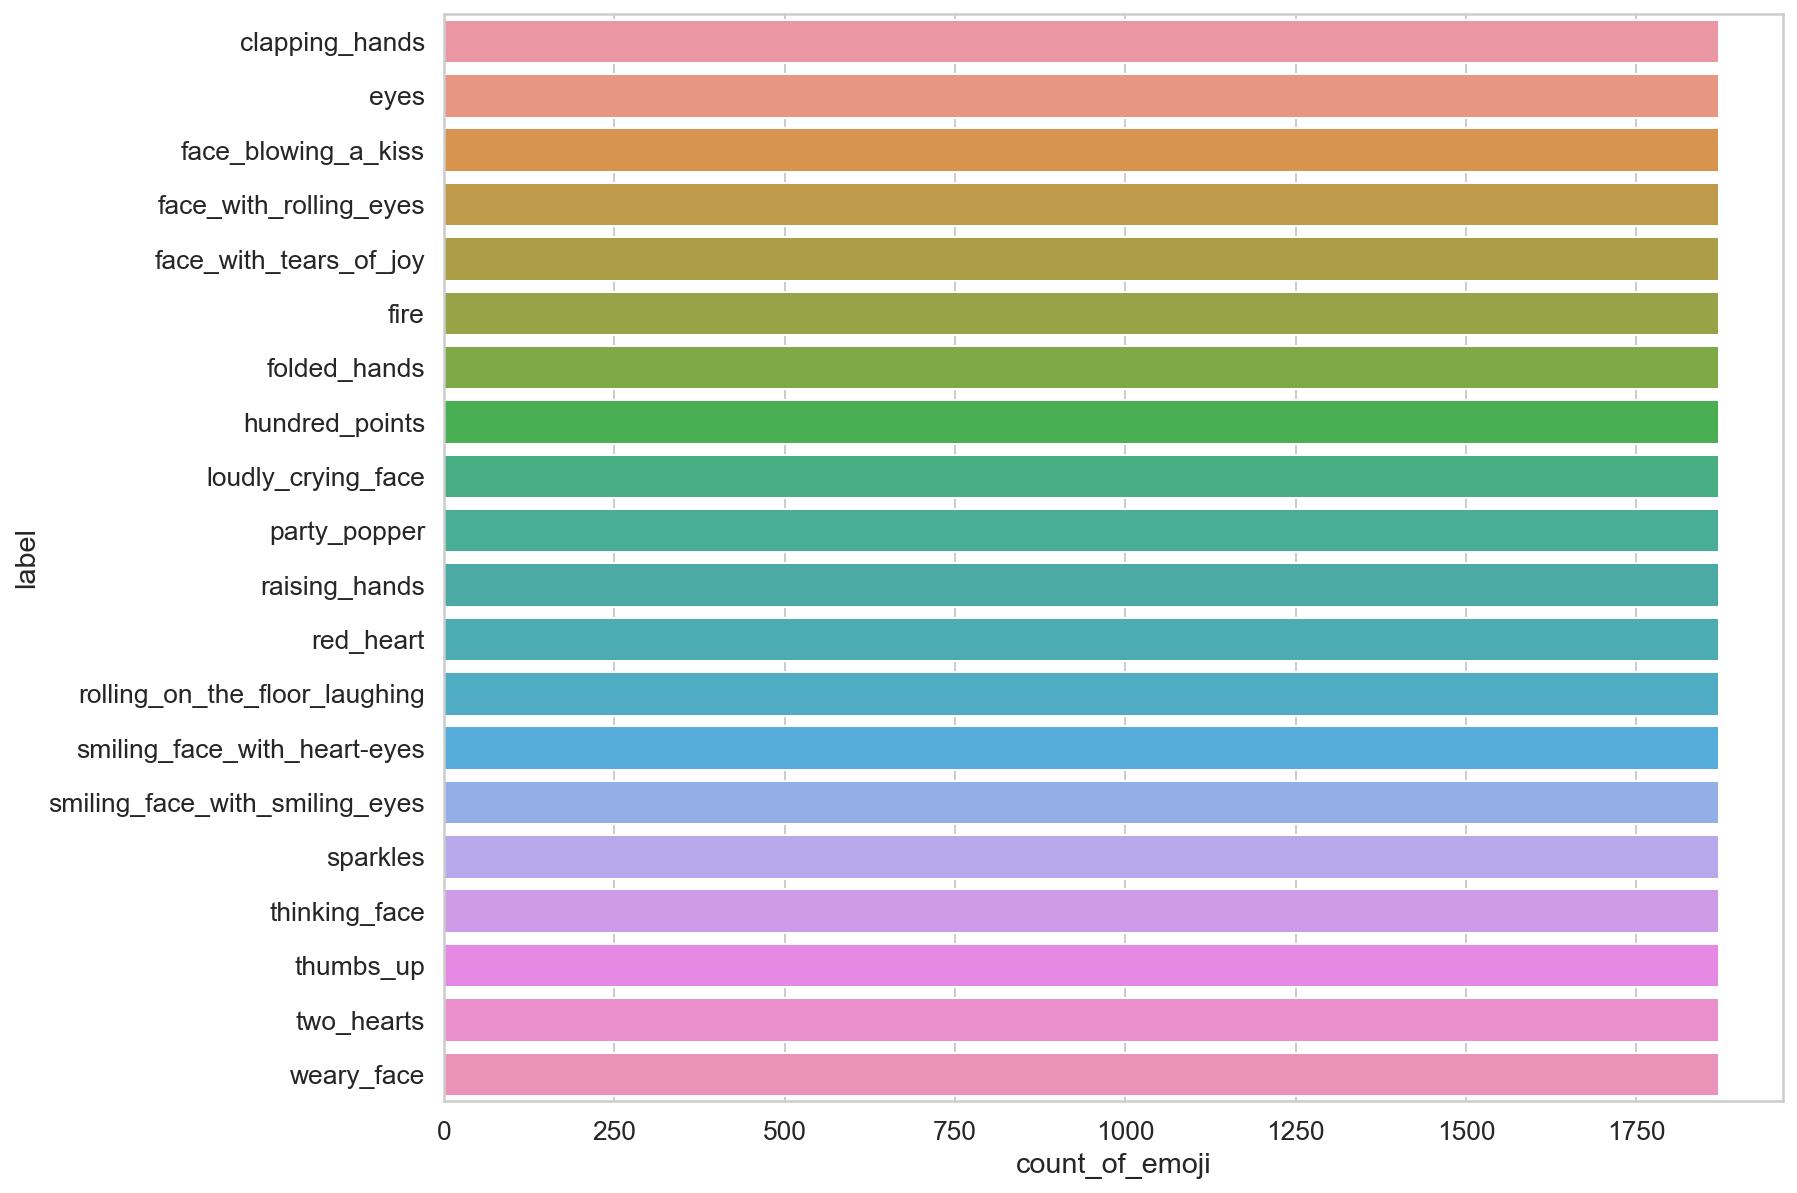

In [19]:
# Print out the count of each class (e.g., each emoji) in the dataset
sns.countplot(y="label", data=df_multiclass_dataset_balanced)
plt.xlabel('count_of_emoji');

### Data Pre-processing

* Add special tokens to seperate setences 
* Pass sequences of constant length using padding 
* Create array of 0s and 1s called attention mask 

In [19]:
# Pretrained model on English language using a masked language modeling (MLM) objective. 
# This model is case-sensitive: it makes a difference between english and English.

PRE_TRAINED_MODEL_NAME = 'bert-base-cased' 

In [20]:
# Initialize BertTokennizer using a pre-trained BERT transformers model as 
# indicated by the "PRE_TRAINED_MODEL_NAME" 
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [21]:
# provide a sample tweet and see how tokenizer works 
sample_txt = 'ranks 6th in January Idol Group Brand Reputation 1Keep using 2Search GOT 7 on Naver htt'

In [22]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# print out the tokenized results : tokens and token_ids
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: ranks 6th in January Idol Group Brand Reputation 1Keep using 2Search GOT 7 on Naver htt
   Tokens: ['ranks', '6th', 'in', 'January', 'Idol', 'Group', 'Brand', 'Rep', '##uta', '##tion', '1', '##K', '##eep', 'using', '2', '##S', '##ear', '##ch', 'GO', '##T', '7', 'on', 'Na', '##ver', 'h', '##tt']
Token IDs: [6496, 4584, 1107, 1356, 15632, 1990, 12381, 20777, 15012, 2116, 122, 2428, 17059, 1606, 123, 1708, 19386, 1732, 27157, 1942, 128, 1113, 11896, 4121, 177, 3069]


In [23]:
# Special BERT token: '[SEP]' is the marker for ending of a sentence 
tokenizer.sep_token, tokenizer.sep_token_id 

('[SEP]', 102)

In [24]:
# Special token: '[CLS]' is the marker for the start of each sentence
tokenizer.cls_token, tokenizer.cls_token_id  

('[CLS]', 101)

In [25]:
# Special token: '[PAD]' is the marker for padding
tokenizer.pad_token, tokenizer.pad_token_id 

('[PAD]', 0)

In [26]:
# Special token: '[UNK]' for vocabulary that is not in the training set
tokenizer.unk_token, tokenizer.unk_token_id 

('[UNK]', 100)

In [27]:
# Using "encode_plus" method to set the configuration of the tokenizer 
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [28]:
encoding['input_ids'][0]

tensor([  101,  6496,  4584,  1107,  1356, 15632,  1990, 12381, 20777, 15012,
         2116,   122,  2428, 17059,  1606,   123,  1708, 19386,  1732, 27157,
         1942,   128,  1113, 11896,  4121,   177,  3069,   102,     0,     0,
            0,     0])

In [29]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'ranks',
 '6th',
 'in',
 'January',
 'Idol',
 'Group',
 'Brand',
 'Rep',
 '##uta',
 '##tion',
 '1',
 '##K',
 '##eep',
 'using',
 '2',
 '##S',
 '##ear',
 '##ch',
 'GO',
 '##T',
 '7',
 'on',
 'Na',
 '##ver',
 'h',
 '##tt',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [30]:
# Exploratory analysis to determine the max_len used for padding tokens 
token_lens = []

for txt in df_multiclass_dataset_balanced.tweet:
    tokens = tokenizer.encode(txt, max_length=200)
    token_lens.append(len(tokens))

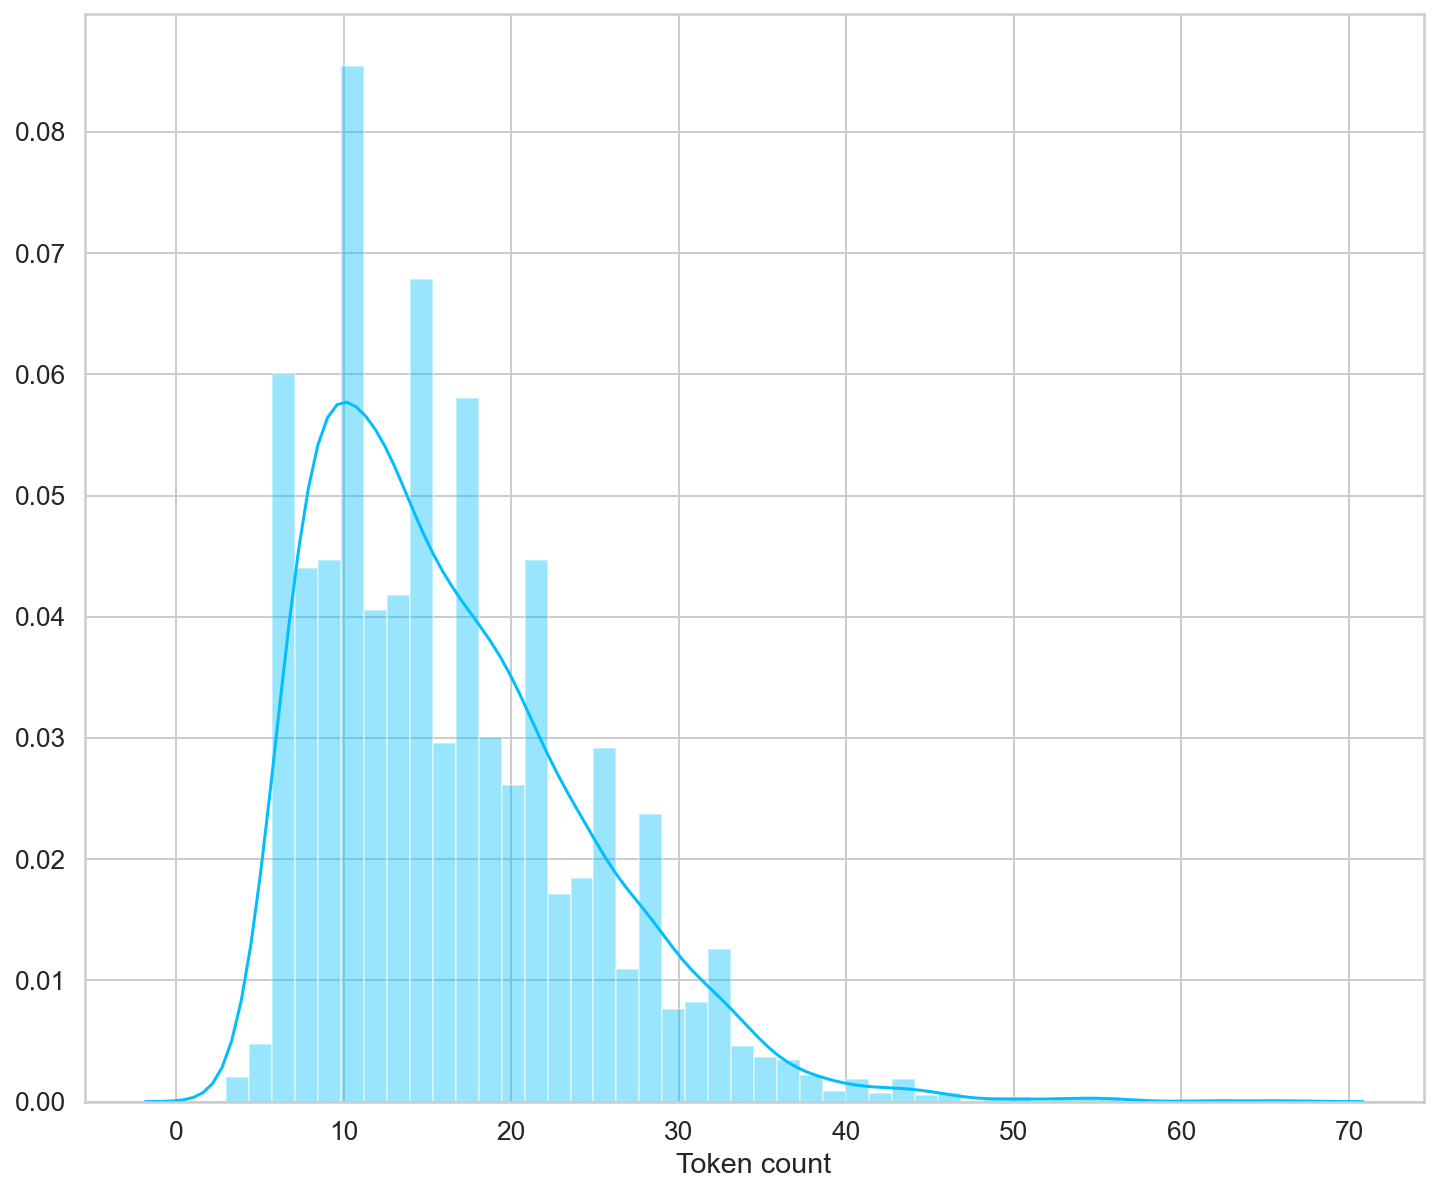

In [31]:
# Plots the token length distribution 
sns.distplot(token_lens)
plt.xlabel('Token count');

In [32]:
# Set MAX_LEN used for padding tokens based on the exploratory analysis result 
MAX_LEN = 60

### Create PyTorch Dataset

In [33]:
# Extending the abstract class "torch.utils.data.Dataset" to create "TweetEmojiDataset" by 
# overriding the following methods:
#  __len__ so that len(dataset) returns the size of the dataset
#  __getitem__ to supporting the indexing such as dataset[i] can be used to get ith sample 

class TweetEmojiDataset(Dataset):
    def __init__(self, tweet, target, tokenizer, max_len):
        self.tweet = tweet
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, item):
        tweet = str(self.tweet[item])
        target = self.target[item]
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.long)
        }

In [34]:
df_train, df_test = train_test_split(df_multiclass_dataset_balanced, test_size=0.1,
                                     random_state=RANDOM_SEED, stratify = df_multiclass_dataset_balanced['label'])

df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [35]:
df_train.shape, df_val.shape, df_test.shape

((3600, 4), (200, 4), (200, 4))

In [36]:
df_train.head()

,tweet,emoji,label,target
id,,,,
1739,Its freaking Plastic not Wood BABE Hahahaha,[loudly_crying_face],loudly_crying_face,8
913,I dont think Im ever gonna get married again bro,[face_with_tears_of_joy],face_with_tears_of_joy,4
2347,all the love and praise the tweets im so happy you did October tho still so jealous i havent seen the film,[red_heart],red_heart,11
2915,I want this to have a happy ending like in a fairy tale for it to be true love forever http,[smiling_face_with_smiling_eyes],smiling_face_with_smiling_eyes,14
945,For the first time in our entire friendship me and have a snap streak Lmao,[face_with_tears_of_joy],face_with_tears_of_joy,4


In [37]:
# df_train.loc[df_train['label']=='flushed_face']

In [38]:
# Using "torch.util.data.DataLoader" to create a dataloader for the TweetEmojiDataset
#   * batching the data based on the definition of batch_size
#   * shuffling the data 
#   * setting num_workers for parallel using multiprocessing workers 
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetEmojiDataset(
        tweet=df.tweet.to_numpy(),
        target=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0)

In [39]:
# Create dataloader for train,test,and validation dataset 
BATCH_SIZE = 16 # Common batch sizes 16, 32, and 64 can be used

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [40]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'target'])

In [41]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['target'].shape)

torch.Size([16, 60])
torch.Size([16, 60])
torch.Size([16])


### Emoji Classifier

In [42]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [43]:
class EmojiClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EmojiClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.1)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask)
        output = self.drop(pooled_output)
        output = self.linear(output)
        return output

In [44]:
model = EmojiClassifier(len(emoji_class))
model = model.to(device)

In [45]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 60])
torch.Size([16, 60])


### Train Model

In [46]:
EPOCHS = 10 # 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

print('Number of Epochs: {}'.format(EPOCHS))
print('Total Steps: {}'.format(total_steps))

Number of Epochs: 10
Total Steps: 2250


In [47]:
# Help function to train model
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["target"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask)
        
        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)
        
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # print("Train Phase::Targets: {}".format(targets))
        # print("Train Phase::Outputs: {}".format(outputs))
        # print("Train Phase::Preds: {}".format(preds))
        # print("Train Phase::Loss: {}".format(loss))
        # print("Train Phase::Correct Prediction: {}".format(torch.sum(preds == targets)))

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [48]:
# Help function to eval model
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["target"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
            # print("Eval Phase::Targets: {}".format(targets))
            # print("Eval Phase::Outputs: {}".format(outputs))
            # print("Eval Phase::Preds: {}".format(preds))
            # print("Eval Phase::Loss: {}".format(loss))
            # print("Eval Phase::Correct Prediction: {}".format(torch.sum(preds == targets)))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
%%time
# Train Model

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(df_train))
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(model,val_data_loader,loss_fn,device,len(df_val))
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 2.88674000316196 accuracy 0.09472222222222222
Val   loss 2.7090198260087233 accuracy 0.21

Epoch 2/10
----------
Train loss 2.4866539080937704 accuracy 0.23444444444444446
Val   loss 2.576121421960684 accuracy 0.22

Epoch 3/10
----------
Train loss 1.9137124813927544 accuracy 0.4266666666666667
Val   loss 2.556193241706261 accuracy 0.255

Epoch 4/10
----------
Train loss 1.3698555024464925 accuracy 0.6247222222222222
Val   loss 2.7144336700439453 accuracy 0.26

Epoch 5/10
----------
Train loss 0.9428033275074429 accuracy 0.7619444444444444
Val   loss 2.88530865082374 accuracy 0.255

Epoch 6/10
----------
Train loss 0.6456572429339091 accuracy 0.8569444444444444
Val   loss 2.921788894213163 accuracy 0.255

Epoch 7/10
----------
Train loss 0.4543465463320414 accuracy 0.9125
Val   loss 3.051161582653339 accuracy 0.25

Epoch 8/10
----------
Train loss 0.3215440633561876 accuracy 0.9491666666666667
Val   loss 3.1560035668886623 accuracy 0.245

Epoch 9/10
---

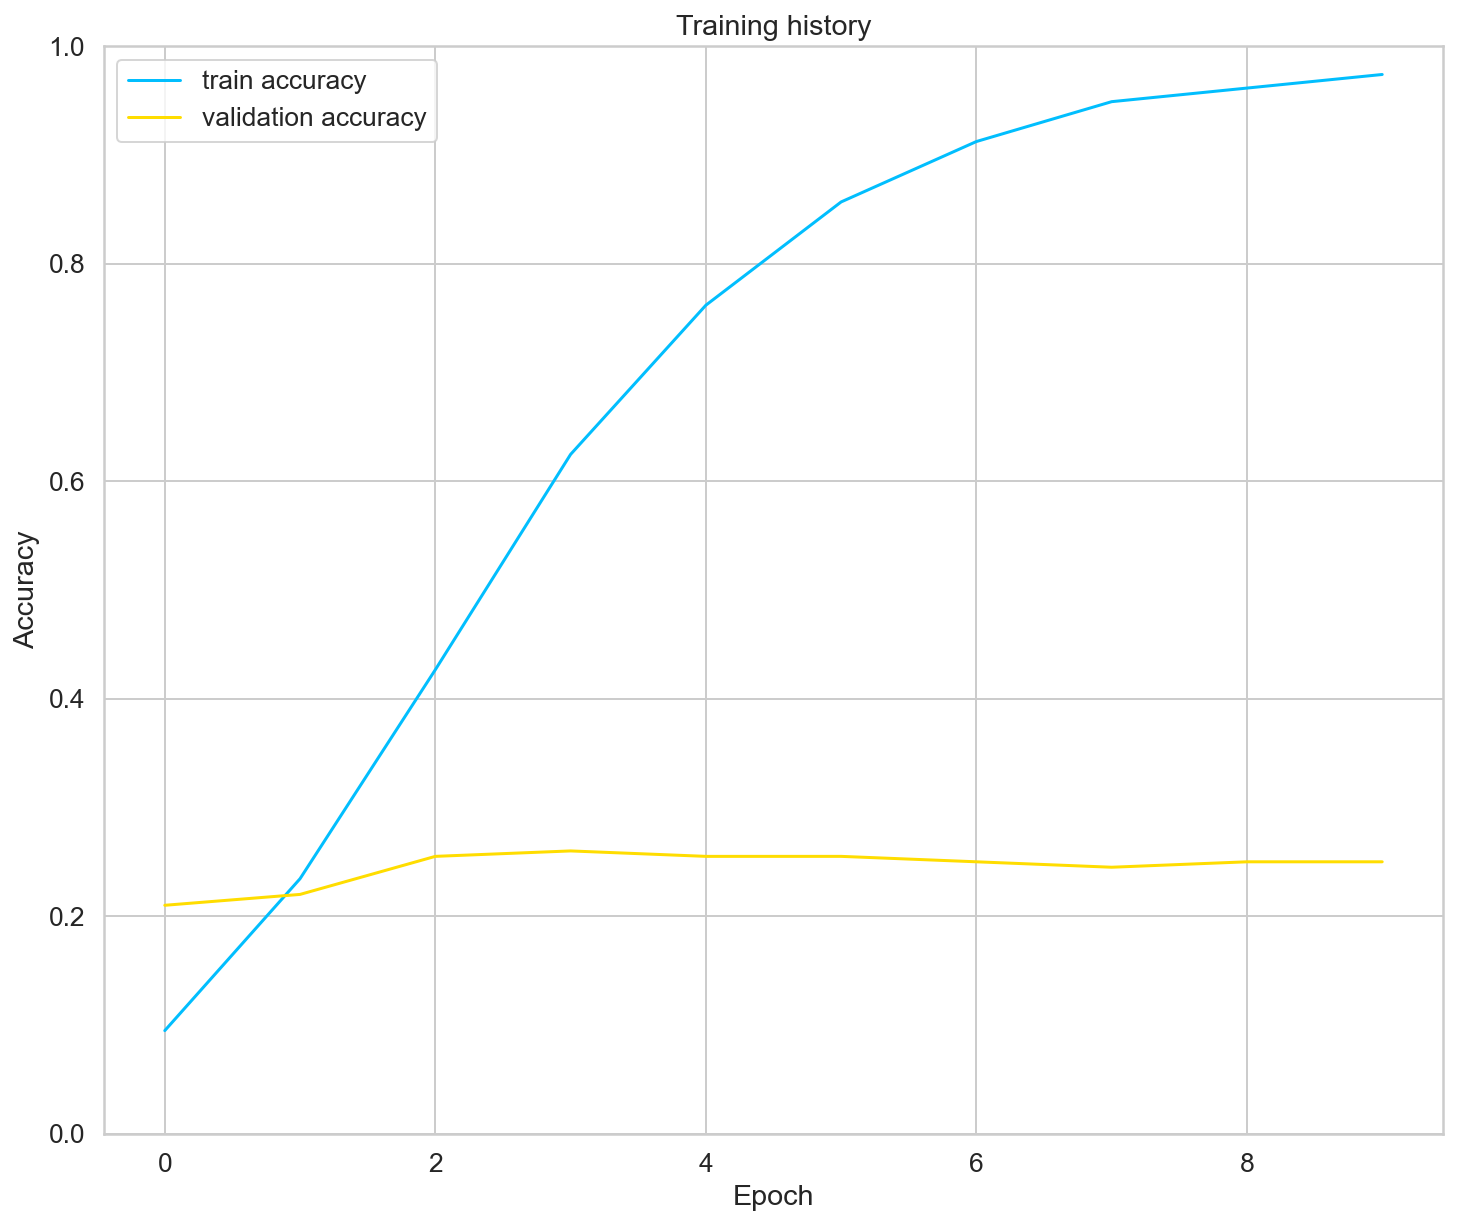

In [50]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluate Model

In [51]:
test_acc, _ = eval_model(model,test_data_loader,loss_fn,device,len(df_test))

test_acc.item()

0.235

In [52]:
# Help function to generate model performance metrics based on test dataset 
def get_predictions(model, data_loader):
    model = model.eval()
    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["target"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = nn.functional.softmax(outputs, dim=1)
            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
        
        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
        return tweet_texts, predictions, prediction_probs, real_values

In [53]:
tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

In [54]:
print(classification_report(y_test, y_pred, target_names= list(emoji_class)))

                                precision    recall  f1-score   support

        face_with_tears_of_joy       0.14      0.20      0.17        10
                     red_heart       0.17      0.29      0.21         7
            loudly_crying_face       0.33      0.45      0.38        11
  smiling_face_with_heart-eyes       0.43      0.30      0.35        10
                          fire       0.12      0.14      0.13         7
                    weary_face       0.36      0.33      0.35        12
                 thinking_face       0.25      0.11      0.15         9
                  folded_hands       0.33      0.25      0.29         8
                    two_hearts       0.22      0.18      0.20        11
smiling_face_with_smiling_eyes       0.78      0.58      0.67        12
                      sparkles       0.33      0.15      0.21        13
                 raising_hands       0.00      0.00      0.00         8
                          eyes       0.28      0.42      0.33  

In [55]:
df_prediction = pd.DataFrame(
    {'tweet_texts': tweet_texts,
     'emoji': y_pred,
     'predicted_emoji': y_test
    })
df_prediction['emoji'] = label_encoder.inverse_transform(df_prediction['emoji'])
df_prediction['predicted_emoji'] = label_encoder.inverse_transform(df_prediction['predicted_emoji'])

In [56]:
df_prediction['emoji'] = [emoji.emojize(':'+ e +':') for e in df_prediction['emoji'].values]
df_prediction['predicted_emoji'] = [emoji.emojize(':'+ e +':') for e in df_prediction['predicted_emoji'].values]

In [59]:
df_prediction.head(20)

,tweet_texts,emoji,predicted_emoji
0,Hahahaha nah If I see an opportunity to make a joke or a pun I just say it I am fully a feminist anyt,🤣,😩
1,Happiest Birthday po Ms sana lage po kayo masaya and healthy Opposites Attract by McCoy De Leon and Elis,😊,😘
2,you looked amazing and felt good in your body thats all that matters so happy for you good seeing u this weekend sh,😘,❤
3,Throw around like confetti,😂,🎉
4,RT if you Terry,🤣,❤
5,How extra is your mum This is a conversation between her and my brother on her birthday,👏,😭
6,Stay away from girls that dont ask Yours After you ask how was your day,😊,🤣
7,my father helped but my momma raised me so talk to them cant blame me,🤣,🤣
8,So stunning great body and such wondrous eyes,😍,😘
9,she made my dayyy,😭,❤
